# 0 Longitude

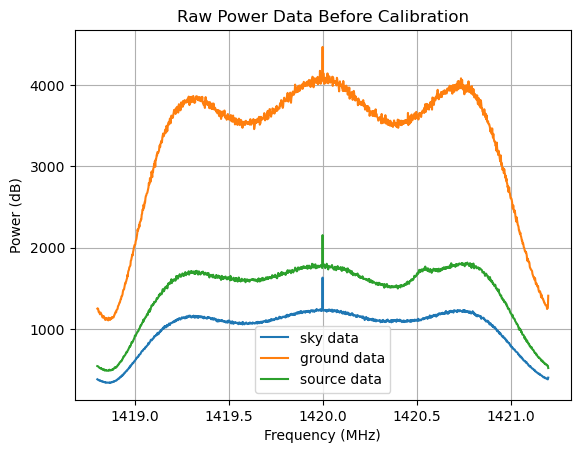

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from scipy.signal import find_peaks, savgol_filter

# Load sky, ground, and source data
sky_file_path1 = "C:\\Users\\DELL\\OneDrive\\Desktop\\ProjH1\\python rtlsdr data\\v6\\s1.csv"
ground_file_path1 = "C:\\Users\\DELL\\OneDrive\\Desktop\\ProjH1\\python rtlsdr data\\v6\\g1.csv"
source_file_path0 = "C:\\Users\\DELL\\OneDrive\\Desktop\\ProjH1\\python rtlsdr data\\v6\\0.csv"

sky_data1 = pd.read_csv(sky_file_path)
ground_data1 = pd.read_csv(ground_file_path)
source_data0 = pd.read_csv(source_file_path)

# Extract frequency and power values
freq_sky1 = (sky_data["Frequency (Hz)"] / 1e6).values  # Convert to NumPy array
freq_gnd1 = (ground_data["Frequency (Hz)"] / 1e6).values
freq_src0 = (source_data["Frequency (Hz)"] / 1e6).values
sky_power_dB = sky_data["Power (dB)"]
ground_power_dB = ground_data["Power (dB)"]
source_power_dB = source_data["Power (dB)"]

# ---- Convert dB to Linear Scale ----
P_ground1 = 10 ** (ground_power_dB / 10)
P_sky1 = 10 ** (sky_power_dB / 10)
P_source0 = 10 ** (source_power_dB / 10)



plt.plot(freq_sky1, P_sky1, label="sky data")
plt.plot(freq_gnd1, P_ground1, label="ground data")
plt.plot(freq_src0, P_source0, label="source data")
plt.legend()

plt.xlabel("Frequency (MHz)")
plt.ylabel("Power (dB)")
plt.title("Raw Power Data Before Calibration")
plt.legend()
plt.grid()
plt.show()


# ---- Baseline Correction (Optional) ----
P_ground_s = savgol_filter(P_ground0, window_length=51, polyorder=3)
P_sky_s = savgol_filter(P_sky, window_length=51, polyorder=3)
P_source_s = savgol_filter(P_source, window_length=51, polyorder=3)


123.93670808775829


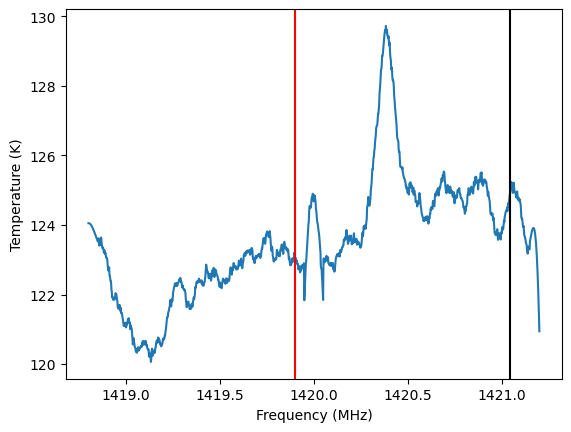

In [4]:
T_sky=5
T_gnd=300

# Compute receiver system temperature (T_r)
T_r0 = (T_sky * (P_ground_s / P_sky_s) - T_gnd) / (1 - (P_ground_s / P_sky_s))

start1= 550
stop1 = 1120



plt.plot(freq_sky, T_r, label="receiver temp")
plt.axvline(freq_sky[start1], color = 'red')
plt.axvline(freq_sky[stop1], color = 'k')
plt.xlabel("Frequency (MHz)")
plt.ylabel("Temperature (K)")

def make_line(array, start, stop):
    avg = (array[start]+array[stop])/2
    arr = np.zeros(len(array))
    for i in range(len(array)):
        if i > start and i < stop:
            arr[i] = avg
        else:
            arr[i] = array[i]
    print(avg)
    return arr

T_rc= make_line(T_r, start1, stop1)

123.93670808775829


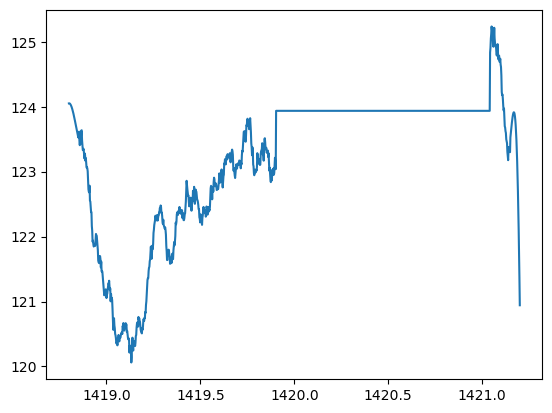

In [43]:
T_rc= make_line(T_r, start1, stop1)
plt.plot(freq_sky, T_rc, label="receiver temp")

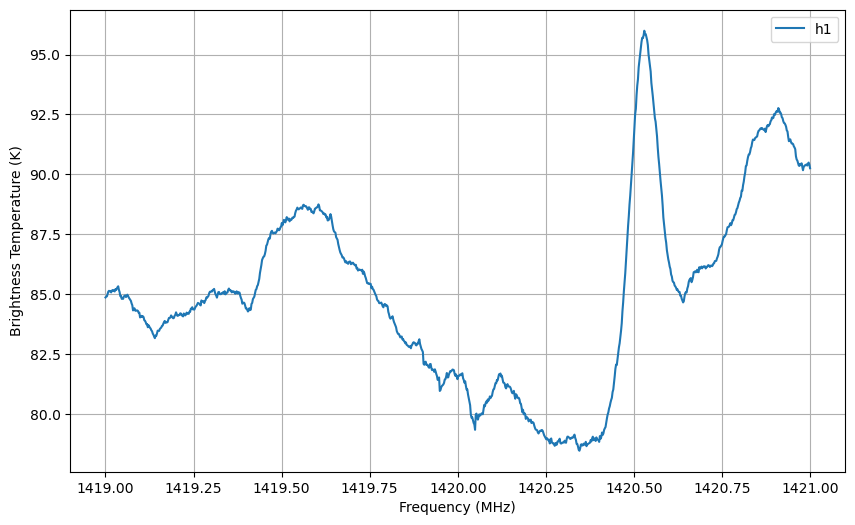

In [45]:
# Compute calibrated brightness temperature for the source
T_src = ((T_gnd + T_rc) / (P_ground_s / P_source_s)) - T_rc
T_s = T_src + 20  # Shift values to bring them above zero

# Define frequency range to keep (adjust as needed)
freq_min = 1419.0  # MHz
freq_max = 1421.0  # MHz

# Apply mask to keep only frequencies in the selected range
mask = (freq_src >= freq_min) & (freq_src <= freq_max)

# Trim the frequency and brightness temperature data
freq_src_t = freq_src[mask]
T_s_t = T_s[mask]

# Plot the trimmed data
plt.figure(figsize=(10,6))
plt.plot(freq_src_t, T_s_t, label="h1")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Brightness Temperature (K)")
plt.legend()
plt.grid()
plt.show()


Peak Velocity: -26.10 km/s, Peak Temperature: 95.99 K


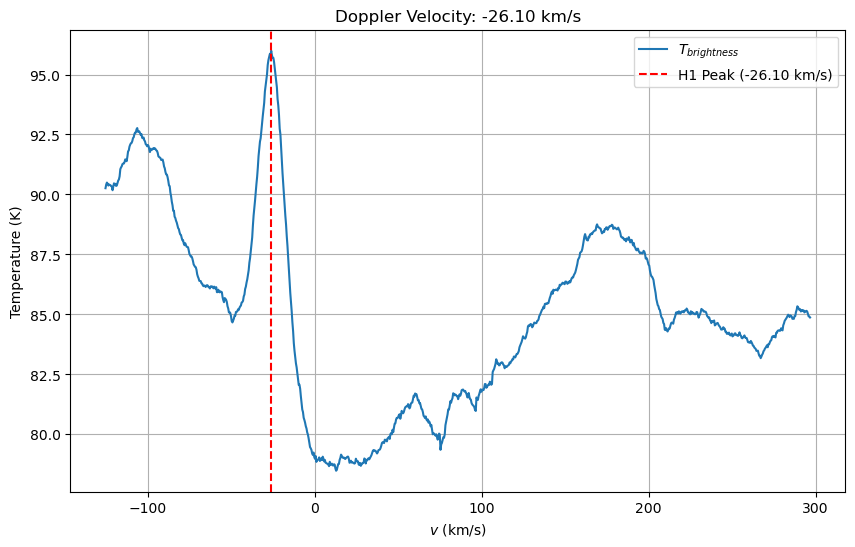

In [47]:
c = 299792.458

v = c* (1- freq_src_t/1420.405751768)

# Find highest peak and corresponding velocity
peak_idx = np.argmax(T_s_t)
peak_velocity = v[peak_idx]
peak_temperature = T_s_t[peak_idx]

print(f"Peak Velocity: {peak_velocity:.2f} km/s, Peak Temperature: {peak_temperature:.2f} K")


plt.figure(figsize=(10,6))
plt.grid()
plt.plot(v, T_s_t, label='$T_{brightness}$')
plt.axvline(peak_velocity, color="red", linestyle="dashed", label=f"H1 Peak ({peak_velocity:.2f} km/s)")
#plt.xticks(range(-250,250,50))
plt.title(f"Doppler Velocity: {peak_velocity:.2f} km/s")
plt.xlabel('$v$ (km/s)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.show()

RA:  268.3489526721784
DEC:  -29.615860219016838


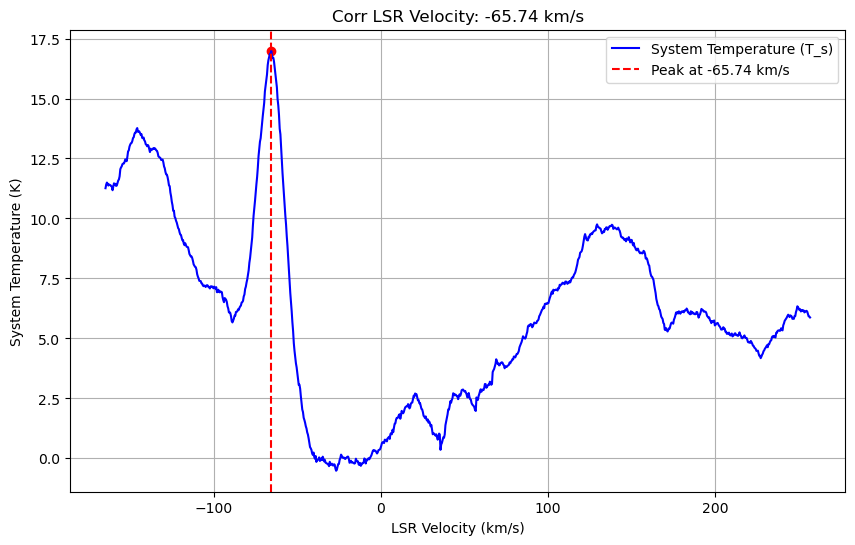

Peak System Temperature: 16.99 K at LSR Velocity: -65.74 km/s


In [49]:
from astropy.time import Time
from astropy.coordinates import EarthLocation, AltAz, ICRS, Galactic, Angle
from astropy.coordinates import get_sun
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from PyAstronomy import pyasl
import math

def compute_lsr_velocity(az, el, lat, lon, alt, obs_time, v_obs):
    """
    Convert Azimuth/Elevation to LSR velocity correction.
    
    Parameters:
    az (float): Azimuth in degrees
    el (float): Elevation in degrees
    lat (float): Latitude of observer in degrees
    lon (float): Longitude of observer in degrees
    alt (float): Altitude of observer in meters
    obs_time (str): Observation time in 'YYYY-MM-DD HH:MM:SS' UTC format
    v_obs (array): Observed velocity from Doppler shift (km/s)
    
    Returns:
    array: LSR-corrected velocity (km/s)
    """
    # Define observer location
    location = EarthLocation(lat=lat*u.deg, lon=lon*u.deg, height=alt*u.m)
    
    # Convert observation time to Astropy Time object
    # Convert IST to UTC (IST is UTC+5:30)
    ist_time = Time(obs_time)
    utc_time = ist_time - 5.5 * u.hour
    time = utc_time
    
    # Compute Local Sidereal Time (LST)
    lst = time.sidereal_time('apparent', longitude=lon*u.deg)
    
    # Define AltAz frame
    altaz = AltAz(obstime=time, location=location)
    
    # Convert Az/El to RA/Dec
    source_altaz = AltAz(az=az*u.deg, alt=el*u.deg, obstime=time, location=location)
    from astropy.coordinates import SkyCoord
    source_altaz = SkyCoord(az=az*u.deg, alt=el*u.deg, frame=AltAz(obstime=time, location=location))
    source_radec = source_altaz.transform_to(ICRS)
    ra = source_radec.ra.deg  # Right Ascension
    dec = source_radec.dec.deg  # Declination

    print("RA: ", ra)
    print("DEC: ", dec)
    
    # Compute Barycentric correction
    #jd = pyasl.jdcnv(time)
    jd = time.jd  # Convert observation time to Julian Date
    corr, hjd = pyasl.helcorr(lon, lat, alt, ra, dec, jd, debug=False)
    
    # Compute Solar Apex motion correction
    v_sun = 20.5  # km/s (Sun's peculiar velocity relative to LSR)
    sun_ra = math.radians(270.2)
    sun_dec = math.radians(28.7)
    obs_ra = math.radians(ra)
    obs_dec = math.radians(dec)
    
    a = math.cos(sun_dec) * math.cos(obs_dec)
    b = (math.cos(sun_ra) * math.cos(obs_ra)) + (math.sin(sun_ra) * math.sin(obs_ra))
    c = math.sin(sun_dec) * math.sin(obs_dec)
    v_rs = v_sun * ((a * b) + c)
    
    # Compute final LSR velocity correction
    v_lsr = corr + v_rs  # Apply same convention as instructor
    
    # Compute LSR-corrected velocity
    v_lsr_corrected = v_obs - v_lsr  # Standard convention
    
    return v_lsr_corrected

# Example usage
azimuth = 230  # Replace with actual Azimuth in degrees
elevation = 17  # Replace with actual Elevation in degrees
latitude = 18.0   # Replace with telescope latitude in degrees
longitude = 78.0  # Replace with telescope longitude in degrees
altitude = 600    # Replace with telescope altitude in meters
obs_time = "2025-03-8 10:58:00"  # Replace with actual observation time (UTC)
v_obs = v  # Replace with observed velocity from Doppler shift (km/s)

v_lsr_final = compute_lsr_velocity(azimuth, elevation, latitude, longitude, altitude, obs_time, v_obs)


#T_b = T_s_t - 79


# Find the peak of T_s
peak_index = np.argmax(T_s_t)
peak_velocity = v_lsr_final[peak_index]
peak_temp = T_b[peak_index]

# Plot T_s vs. LSR Velocity
plt.figure(figsize=(10,6))
plt.plot(v_lsr_final, T_b, label='System Temperature (T_s)', linestyle='solid', color='blue')

# Mark the peak
plt.axvline(x=peak_velocity, color='red', linestyle='dashed', label=f'Peak at {peak_velocity:.2f} km/s')
plt.scatter(peak_velocity, peak_temp, color='red', marker='o')

plt.xlabel("LSR Velocity (km/s)")
plt.ylabel("System Temperature (K)")
plt.title(f"Corr LSR Velocity: {peak_velocity:.2f} km/s")
plt.legend()
plt.grid()
plt.show()

# Print peak values
print(f"Peak System Temperature: {peak_temp:.2f} K at LSR Velocity: {peak_velocity:.2f} km/s")


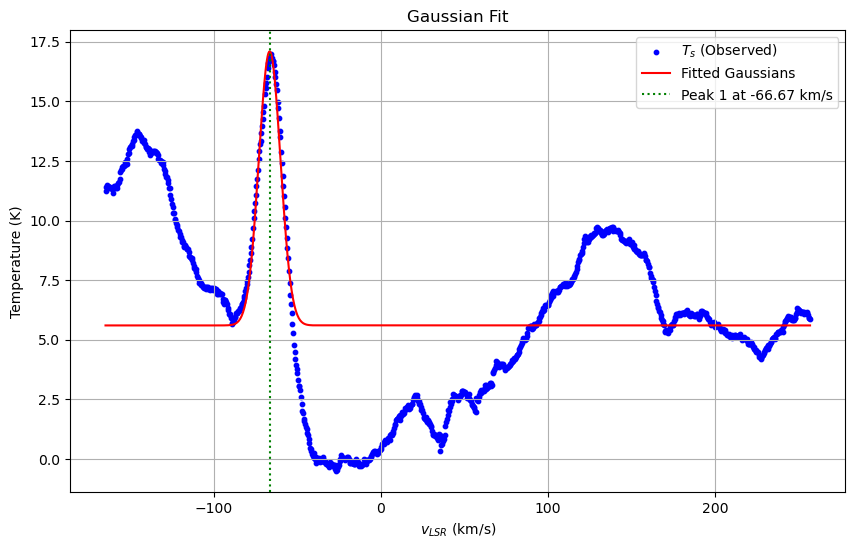

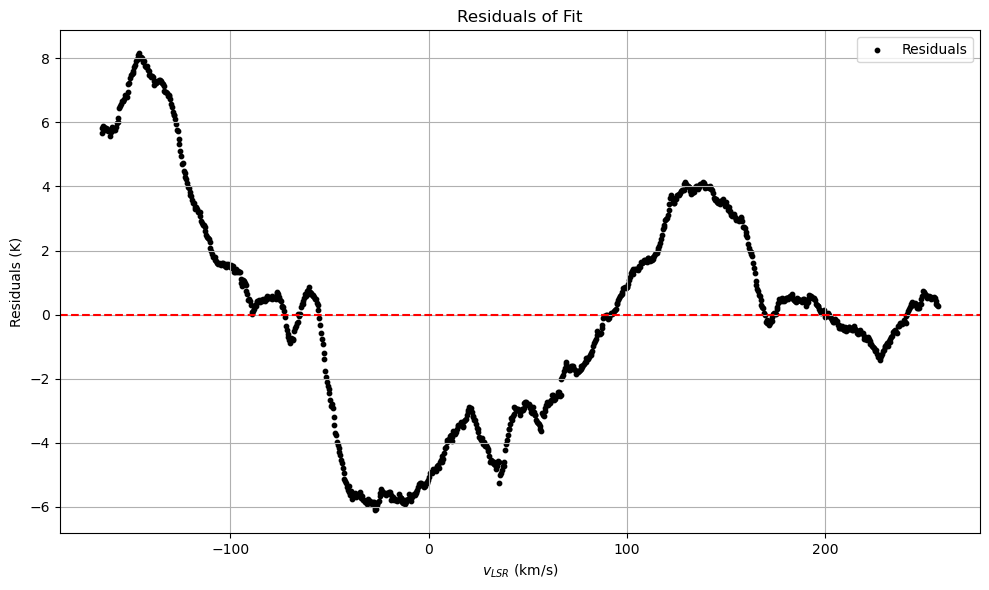

Peak 1 Velocity: -66.67 km/s


In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Gaussian function
def gaussian(x, amplitude, mean, sigma, shift):
    return amplitude * np.exp(-((x - mean)**2) / (2 * sigma**2)) + shift

# Sum of multiple Gaussians
def sum_of_gaussians(x, *params):
    n_gaussians = len(params) // 4  # 4 parameters per Gaussian
    y = np.zeros_like(x)
    for i in range(n_gaussians):
        amplitude = params[4 * i]
        mean = params[4 * i + 1]
        sigma = params[4 * i + 2]
        shift = params[4 * i + 3]
        y += gaussian(x, amplitude, mean, sigma, shift)
    return y

# Fit function
def fit_gaussians(x_data, y_data, n_gaussians, initial_guesses):
    if len(initial_guesses) != n_gaussians * 4:
        raise ValueError("Initial guesses must have 4 parameters per Gaussian (amp, mean, sigma, shift).")
    try:
        popt, _ = curve_fit(lambda x, *params: sum_of_gaussians(x, *params), x_data, y_data, p0=initial_guesses)
        return popt
    except Exception as e:
        print(f"Fitting failed: {e}")
        return None

# Your data (Replace with actual variables)
x_data = v_lsr_final  # LSR velocity
y_data = T_b          # Brightness Temperature

# Number of Gaussians to fit
n_gaussians = 1  # Adjust as needed

# Initial guesses [amp1, mean1, sigma1, shift1, amp2, mean2, sigma2, shift2, ...]
initial_guesses = [95, -65, 20, 0, ]  # Adjust manually

# Fit the data
popt = fit_gaussians(x_data, y_data, n_gaussians, initial_guesses)

# Plot results
if popt is not None:
    fitted_y = sum_of_gaussians(x_data, *popt)
    residuals = y_data - fitted_y  # Compute residuals

    plt.figure(figsize=(10, 6))

    # Plot original data and fit
    plt.plot(2, 1, 1)
    plt.scatter(x_data, y_data, s=10, label="$T_s$ (Observed)", color="blue")
    plt.plot(x_data, fitted_y, label="Fitted Gaussians", color="red")
    plt.axvline(popt[1], color='green', linestyle='dotted', label=f'Peak 1 at {popt[1]:.2f} km/s')
   # plt.axvline(popt[5], color='purple', linestyle='dotted', label=f'Peak 2 at {popt[5]:.2f} km/s')
    plt.legend()
    plt.xlabel('$v_{LSR}$ (km/s)')
    plt.ylabel('Temperature (K)')
    plt.title("Gaussian Fit")
    plt.grid()

    plt.figure(figsize=(10, 6))
    # Plot residuals
    plt.plot(2, 1, 2)
    plt.scatter(x_data, residuals, s=10, color='black', label="Residuals")
    plt.axhline(0, color='red', linestyle='dashed')
    plt.xlabel('$v_{LSR}$ (km/s)')
    plt.ylabel('Residuals (K)')
    plt.title("Residuals of Fit")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

    print(f"Peak 1 Velocity: {popt[1]:.2f} km/s")
    #print(f"Peak 2 Velocity: {popt[5]:.2f} km/s")


# 10 Longitude

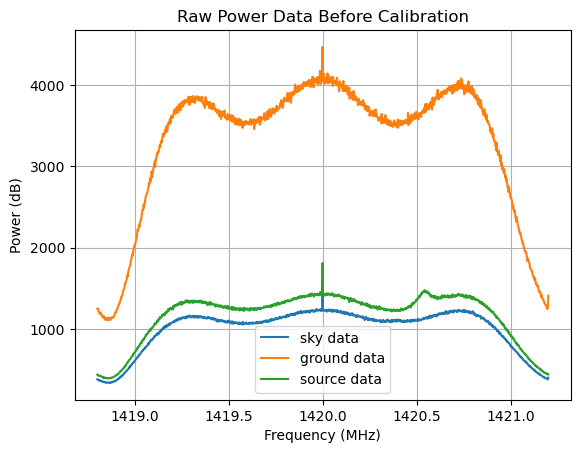

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from scipy.signal import find_peaks, savgol_filter

# Load sky, ground, and source data
sky_file_path = "C:\\Users\\DELL\\OneDrive\\Desktop\\ProjH1\\python rtlsdr data\\v6\\s1.csv"
ground_file_path = "C:\\Users\\DELL\\OneDrive\\Desktop\\ProjH1\\python rtlsdr data\\v6\\g1.csv"
source_file_path = "C:\\Users\\DELL\\OneDrive\\Desktop\\ProjH1\\python rtlsdr data\\v6\\10.csv"

sky_data = pd.read_csv(sky_file_path)
ground_data = pd.read_csv(ground_file_path)
source_data = pd.read_csv(source_file_path)

# Extract frequency and power values
freq_sky = (sky_data["Frequency (Hz)"] / 1e6).values  # Convert to NumPy array
freq_gnd = (ground_data["Frequency (Hz)"] / 1e6).values
freq_src = (source_data["Frequency (Hz)"] / 1e6).values
sky_power_dB = sky_data["Power (dB)"]
ground_power_dB = ground_data["Power (dB)"]
source_power_dB = source_data["Power (dB)"]

# ---- Convert dB to Linear Scale ----
P_ground = 10 ** (ground_power_dB / 10)
P_sky = 10 ** (sky_power_dB / 10)
P_source = 10 ** (source_power_dB / 10)



plt.plot(freq_sky, P_sky, label="sky data")
plt.plot(freq_gnd, P_ground, label="ground data")
plt.plot(freq_src, P_source, label="source data")
plt.legend()

plt.xlabel("Frequency (MHz)")
plt.ylabel("Power (dB)")
plt.title("Raw Power Data Before Calibration")
plt.legend()
plt.grid()
plt.show()


# ---- Baseline Correction (Optional) ----
P_ground_s = savgol_filter(P_ground, window_length=51, polyorder=3)
P_sky_s = savgol_filter(P_sky, window_length=51, polyorder=3)
P_source_s = savgol_filter(P_source, window_length=51, polyorder=3)


123.93670808775829
123.93670808775829


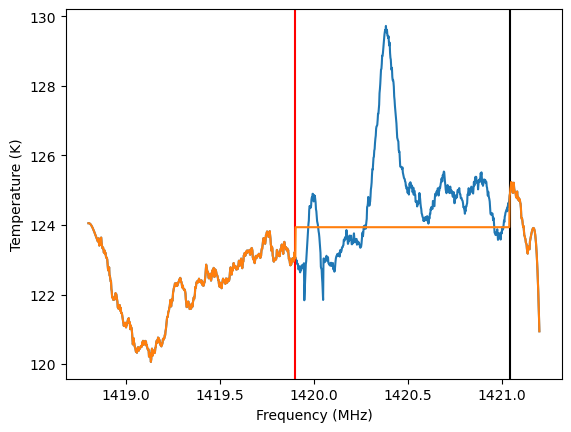

In [55]:
T_sky=5
T_gnd=300

# Compute receiver system temperature (T_r)
T_r = (T_sky * (P_ground_s / P_sky_s) - T_gnd) / (1 - (P_ground_s / P_sky_s))

start1= 550
stop1 = 1120



plt.plot(freq_sky, T_r, label="receiver temp")
plt.axvline(freq_sky[start1], color = 'red')
plt.axvline(freq_sky[stop1], color = 'k')
plt.xlabel("Frequency (MHz)")
plt.ylabel("Temperature (K)")

def make_line(array, start, stop):
    avg = (array[start]+array[stop])/2
    arr = np.zeros(len(array))
    for i in range(len(array)):
        if i > start and i < stop:
            arr[i] = avg
        else:
            arr[i] = array[i]
    print(avg)
    return arr

T_rc= make_line(T_r, start1, stop1)


T_rc= make_line(T_r, start1, stop1)
plt.plot(freq_sky, T_rc, label="receiver temp")

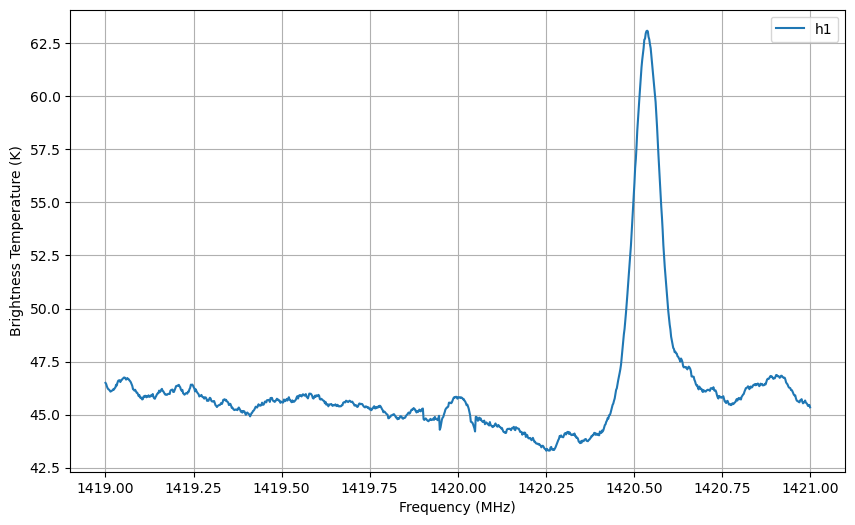

In [57]:
# Compute calibrated brightness temperature for the source
T_src = ((T_gnd + T_rc) / (P_ground_s / P_source_s)) - T_rc
T_s = T_src + 20  # Shift values to bring them above zero

# Define frequency range to keep (adjust as needed)
freq_min = 1419.0  # MHz
freq_max = 1421.0  # MHz

# Apply mask to keep only frequencies in the selected range
mask = (freq_src >= freq_min) & (freq_src <= freq_max)

# Trim the frequency and brightness temperature data
freq_src_t = freq_src[mask]
T_s_t = T_s[mask]

# Plot the trimmed data
plt.figure(figsize=(10,6))
plt.plot(freq_src_t, T_s_t, label="h1")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Brightness Temperature (K)")
plt.legend()
plt.grid()
plt.show()


Peak Velocity: -27.79 km/s, Peak Temperature: 63.09 K


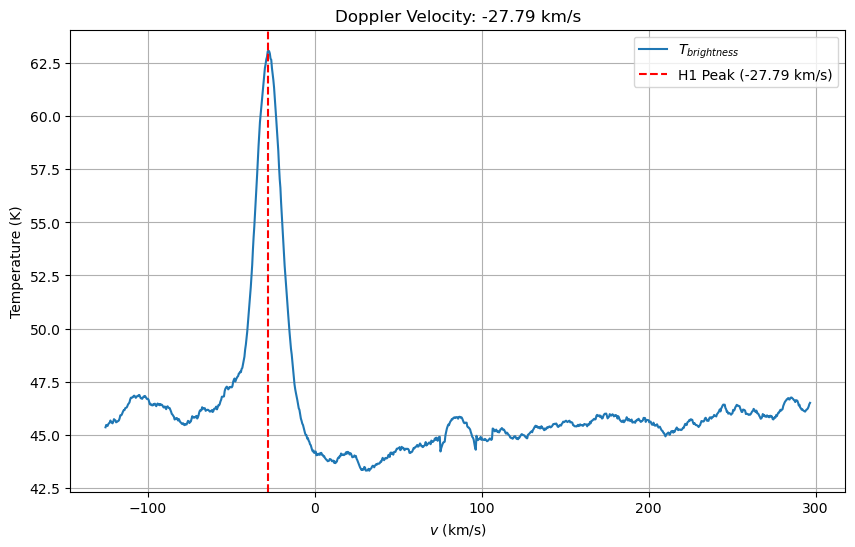

In [59]:
c = 299792.458

v = c* (1- freq_src_t/1420.405751768)

# Find highest peak and corresponding velocity
peak_idx = np.argmax(T_s_t)
peak_velocity = v[peak_idx]
peak_temperature = T_s_t[peak_idx]

print(f"Peak Velocity: {peak_velocity:.2f} km/s, Peak Temperature: {peak_temperature:.2f} K")


plt.figure(figsize=(10,6))
plt.grid()
plt.plot(v, T_s_t, label='$T_{brightness}$')
plt.axvline(peak_velocity, color="red", linestyle="dashed", label=f"H1 Peak ({peak_velocity:.2f} km/s)")
#plt.xticks(range(-250,250,50))
plt.title(f"Doppler Velocity: {peak_velocity:.2f} km/s")
plt.xlabel('$v$ (km/s)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.show()

In [ ]:
from astropy.time import Time
from astropy.coordinates import EarthLocation, AltAz, ICRS, Galactic, Angle
from astropy.coordinates import get_sun
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from PyAstronomy import pyasl
import math

def compute_lsr_velocity(az, el, lat, lon, alt, obs_time, v_obs):
    """
    Convert Azimuth/Elevation to LSR velocity correction.
    
    Parameters:
    az (float): Azimuth in degrees
    el (float): Elevation in degrees
    lat (float): Latitude of observer in degrees
    lon (float): Longitude of observer in degrees
    alt (float): Altitude of observer in meters
    obs_time (str): Observation time in 'YYYY-MM-DD HH:MM:SS' UTC format
    v_obs (array): Observed velocity from Doppler shift (km/s)
    
    Returns:
    array: LSR-corrected velocity (km/s)
    """
    # Define observer location
    location = EarthLocation(lat=lat*u.deg, lon=lon*u.deg, height=alt*u.m)
    
    # Convert observation time to Astropy Time object
    # Convert IST to UTC (IST is UTC+5:30)
    ist_time = Time(obs_time)
    utc_time = ist_time - 5.5 * u.hour
    time = utc_time
    
    # Compute Local Sidereal Time (LST)
    lst = time.sidereal_time('apparent', longitude=lon*u.deg)
    
    # Define AltAz frame
    altaz = AltAz(obstime=time, location=location)
    
    # Convert Az/El to RA/Dec
    source_altaz = AltAz(az=az*u.deg, alt=el*u.deg, obstime=time, location=location)
    from astropy.coordinates import SkyCoord
    source_altaz = SkyCoord(az=az*u.deg, alt=el*u.deg, frame=AltAz(obstime=time, location=location))
    source_radec = source_altaz.transform_to(ICRS)
    ra = source_radec.ra.deg  # Right Ascension
    dec = source_radec.dec.deg  # Declination

    print("RA: ", ra)
    print("DEC: ", dec)
    
    # Compute Barycentric correction
    #jd = pyasl.jdcnv(time)
    jd = time.jd  # Convert observation time to Julian Date
    corr, hjd = pyasl.helcorr(lon, lat, alt, ra, dec, jd, debug=False)
    
    # Compute Solar Apex motion correction
    v_sun = 20.5  # km/s (Sun's peculiar velocity relative to LSR)
    sun_ra = math.radians(270.2)
    sun_dec = math.radians(28.7)
    obs_ra = math.radians(ra)
    obs_dec = math.radians(dec)
    
    a = math.cos(sun_dec) * math.cos(obs_dec)
    b = (math.cos(sun_ra) * math.cos(obs_ra)) + (math.sin(sun_ra) * math.sin(obs_ra))
    c = math.sin(sun_dec) * math.sin(obs_dec)
    v_rs = v_sun * ((a * b) + c)
    
    # Compute final LSR velocity correction
    v_lsr = corr + v_rs  # Apply same convention as instructor
    
    # Compute LSR-corrected velocity
    v_lsr_corrected = v_obs - v_lsr  # Standard convention
    
    return v_lsr_corrected

# Example usage
azimuth = 235  # Replace with actual Azimuth in degrees
elevation = 26  # Replace with actual Elevation in degrees
latitude = 18.0   # Replace with telescope latitude in degrees
longitude = 78.0  # Replace with telescope longitude in degrees
altitude = 600    # Replace with telescope altitude in meters
obs_time = "2025-03-8 10:54:00"  # Replace with actual observation time (UTC)
v_obs = v  # Replace with observed velocity from Doppler shift (km/s)

v_lsr_final = compute_lsr_velocity(azimuth, elevation, latitude, longitude, altitude, obs_time, v_obs)


T_b = T_s_t - 79


# Find the peak of T_s
peak_index = np.argmax(T_s_t)
peak_velocity = v_lsr_final[peak_index]
peak_temp = T_b[peak_index]

# Plot T_s vs. LSR Velocity
plt.figure(figsize=(10,6))
plt.plot(v_lsr_final, T_b, label='System Temperature (T_s)', linestyle='solid', color='blue')

# Mark the peak
plt.axvline(x=peak_velocity, color='red', linestyle='dashed', label=f'Peak at {peak_velocity:.2f} km/s')
plt.scatter(peak_velocity, peak_temp, color='red', marker='o')

plt.xlabel("LSR Velocity (km/s)")
plt.ylabel("System Temperature (K)")
plt.title(f"Corr LSR Velocity: {peak_velocity:.2f} km/s")
plt.legend()
plt.grid()
plt.show()

# Print peak values
print(f"Peak System Temperature: {peak_temp:.2f} K at LSR Velocity: {peak_velocity:.2f} km/s")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Gaussian function
def gaussian(x, amplitude, mean, sigma, shift):
    return amplitude * np.exp(-((x - mean)**2) / (2 * sigma**2)) + shift

# Sum of multiple Gaussians
def sum_of_gaussians(x, *params):
    n_gaussians = len(params) // 4  # 4 parameters per Gaussian
    y = np.zeros_like(x)
    for i in range(n_gaussians):
        amplitude = params[4 * i]
        mean = params[4 * i + 1]
        sigma = params[4 * i + 2]
        shift = params[4 * i + 3]
        y += gaussian(x, amplitude, mean, sigma, shift)
    return y

# Fit function
def fit_gaussians(x_data, y_data, n_gaussians, initial_guesses):
    if len(initial_guesses) != n_gaussians * 4:
        raise ValueError("Initial guesses must have 4 parameters per Gaussian (amp, mean, sigma, shift).")
    try:
        popt, _ = curve_fit(lambda x, *params: sum_of_gaussians(x, *params), x_data, y_data, p0=initial_guesses)
        return popt
    except Exception as e:
        print(f"Fitting failed: {e}")
        return None

# Your data (Replace with actual variables)
x_data = v_lsr_final  # LSR velocity
y_data = T_b          # Brightness Temperature

# Number of Gaussians to fit
n_gaussians = 1  # Adjust as needed

# Initial guesses [amp1, mean1, sigma1, shift1, amp2, mean2, sigma2, shift2, ...]
initial_guesses = [95, -65, 20, 0, ]  # Adjust manually

# Fit the data
popt = fit_gaussians(x_data, y_data, n_gaussians, initial_guesses)

# Plot results
if popt is not None:
    fitted_y = sum_of_gaussians(x_data, *popt)
    residuals = y_data - fitted_y  # Compute residuals

    plt.figure(figsize=(10, 6))

    # Plot original data and fit
    plt.plot(2, 1, 1)
    plt.scatter(x_data, y_data, s=10, label="$T_s$ (Observed)", color="blue")
    plt.plot(x_data, fitted_y, label="Fitted Gaussians", color="red")
    plt.axvline(popt[1], color='green', linestyle='dotted', label=f'Peak 1 at {popt[1]:.2f} km/s')
   # plt.axvline(popt[5], color='purple', linestyle='dotted', label=f'Peak 2 at {popt[5]:.2f} km/s')
    plt.legend()
    plt.xlabel('$v_{LSR}$ (km/s)')
    plt.ylabel('Temperature (K)')
    plt.title("Gaussian Fit")
    plt.grid()

    plt.figure(figsize=(10, 6))
    # Plot residuals
    plt.plot(2, 1, 2)
    plt.scatter(x_data, residuals, s=10, color='black', label="Residuals")
    plt.axhline(0, color='red', linestyle='dashed')
    plt.xlabel('$v_{LSR}$ (km/s)')
    plt.ylabel('Residuals (K)')
    plt.title("Residuals of Fit")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

    print(f"Peak 1 Velocity: {popt[1]:.2f} km/s")
    #print(f"Peak 2 Velocity: {popt[5]:.2f} km/s")
